In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px

from datetime import datetime
import re

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
train_df = pd.read_csv('train.csv')
dataset = train_df.copy()
dataset.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [16]:
dataset.shape

(188533, 13)

In [20]:
# unique car brands in dataset
dataset['brand'].nunique()

57

In [21]:
# Model year minimum & maximum
print(dataset['model_year'].min())
print(dataset['model_year'].max())

1974
2024


In [22]:
dataset.nunique()

id              188533
brand               57
model             1897
model_year          34
milage            6651
fuel_type            7
engine            1117
transmission        52
ext_col            319
int_col            156
accident             2
clean_title          1
price             1569
dtype: int64

In [23]:
dataset.duplicated().sum()

0

In [24]:
# Missing values

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [25]:
dataset.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [28]:
dataset.fuel_type.isna().sum()

5083

In [34]:
dataset.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [41]:
dataset = dataset[~dataset['fuel_type'].isin(['–', 'not supported'])]
dataset.reset_index(drop=True, inplace=True)

In [42]:
dataset.fuel_type.value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
Plug-In Hybrid       521
Name: count, dtype: int64

In [43]:
# fill the missing values in 'fue;_type' column with information extracted from 'engine' column

# Flex pattern
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Flex', case=False, na=False)), 'fuel_type'] = 'E85 Flex Fuel'

#  Hybried patterns
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Dual', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Electric', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Battery', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('kW', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('AH', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Tesla', case=False, na=False)), 'fuel_type'] = 'Hybrid'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Hybrid', case=False, na=False)), 'fuel_type'] = 'Hybrid'

# Gasoline patterns
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('GDI', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('PDI', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('OHV', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('MPFI', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('TFSI', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('DOHC', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Gasoline', case=False, na=False)), 'fuel_type'] = 'Gasoline'
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['model_year'] < 2020), 'fuel_type'] = 'Gasoline'

# Diesel patterns
dataset.loc[(dataset['fuel_type'].isna()) & (dataset['engine'].str.contains('Diesel', case=False, na=False)), 'fuel_type'] = 'Diesel'

In [44]:
dataset[dataset['fuel_type'].isna()]

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
19793,19868,Nissan,Titan SV,2023,4451,NaN,5.3 Liter,Automatic,Anthracite Blue Metallic,Black,None reported,NaN,96998
21965,22048,Tesla,Model X Long Range Plus,2021,30309,NaN,5.0 Liter,Automatic,White,Black,None reported,NaN,59598
34984,35115,Rivian,R1S Adventure Package,2023,15097,NaN,5.5 Liter,Automatic,White,Black,None reported,NaN,58900
43122,43295,Audi,Q4 e-tron Sportback Premium,2021,13613,NaN,2.0 Liter Turbo,Automatic,Navarra Blue Metallic,Black,None reported,NaN,38998
44468,44647,Tesla,Model X Long Range Plus,2022,4665,NaN,5.0 Liter,Automatic,Silver,Black,None reported,NaN,75798
47844,48035,Mercedes-Benz,EQS 450 4MATIC,2022,20104,NaN,4.0 Liter Twin Turbo,Automatic,–,–,None reported,NaN,94998
55604,55826,Land,Rover Range Rover Velar SVAutobiography Dynami...,2021,16184,NaN,V8,Automatic,Fuji White,Black,None reported,NaN,58598
116031,116523,Tesla,Model X Long Range Plus,2021,24906,NaN,5.6 Liter,Automatic,Obsidian Black Metallic,Black,None reported,NaN,47498
148876,149492,Tesla,Model 3 Long Range,2021,23113,NaN,3.0 Liter Turbo,Automatic,Tan,Red,None reported,Yes,32300
149799,150417,Jaguar,F-PACE S,2022,11111,NaN,3.0 Liter,Automatic,Santorini Black Metallic,Ebony / Pimento,None reported,NaN,81900


In [45]:
dataset['fuel_type'] = dataset['fuel_type'].fillna('Hybrid')

In [46]:
# now we will take a lookat the 'clean_title' column and 'accident' column, they are both related

missing_in_clean_title = dataset['clean_title'].isna().sum()
print(f'{missing_in_clean_title} Missing value')
print('=' * 20)

dataset['clean_title'].value_counts()

21393 Missing value


clean_title
Yes    166344
Name: count, dtype: int64

In [47]:
missing_in_accident = dataset['accident'].isna().sum()
print(f'{missing_in_accident} Missing value')
print('=' * 20)

dataset['accident'].value_counts()

2435 Missing value


accident
None reported                             144025
At least 1 accident or damage reported     41277
Name: count, dtype: int64

In [48]:
dataset[dataset['clean_title'].isna()].head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
20,20,Land,Rover Defender S,2023,7978,Gasoline,5.2L V10 40V PDI DOHC,8-Speed Automatic,Santorini Black Metallic,Black,None reported,NaN,41998
45,45,RAM,1500 Laramie,2022,27352,Gasoline,5.7L V8 16V MPFI OHV,8-Speed Automatic,Diamond Black,Black,None reported,NaN,42599
51,51,Tesla,Model 3 Long Range,2020,38360,Hybrid,Dual Motor - Standard,Automatic,White,Black,None reported,NaN,59598
60,60,Mercedes-Benz,GLS 450 Base 4MATIC,2017,44147,Gasoline,3.0L V6 24V GDI DOHC Twin Turbo,9-Speed Automatic,White,Parchment.,At least 1 accident or damage reported,NaN,29999
70,70,McLaren,570S Spider,2023,3254,Gasoline,3.8L V8 32V MPFI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,Vega Blue,Black,None reported,NaN,92500


In [49]:
dataset[dataset['clean_title'].isna() & dataset['accident'] == 'At least 1 accindent or damage reported']

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price


In [50]:
dataset.loc[(dataset['accident'] == 'At least 1 accident or damage reported') & (dataset['clean_title'].isna()), 'clean_title'] = 'Yes'

In [51]:
dataset['clean_title'].isna().sum()

20239

In [52]:
dataset['clean_title'] = dataset['clean_title'].fillna('No')
dataset['accident'] = dataset['accident'].fillna('None reported')

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187737 entries, 0 to 187736
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            187737 non-null  int64 
 1   brand         187737 non-null  object
 2   model         187737 non-null  object
 3   model_year    187737 non-null  int64 
 4   milage        187737 non-null  int64 
 5   fuel_type     187737 non-null  object
 6   engine        187737 non-null  object
 7   transmission  187737 non-null  object
 8   ext_col       187737 non-null  object
 9   int_col       187737 non-null  object
 10  accident      187737 non-null  object
 11  clean_title   187737 non-null  object
 12  price         187737 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.6+ MB


In [54]:
print(dataset['price'].min())
print(dataset['price'].max())

2000
2954083


In [55]:
dataset[dataset['price']>=2954083][['brand', 'price', 'milage', 'model_year']].head(5)

,brand,price,milage,model_year
220,Ford,2954083,26315,2021
1874,Chrysler,2954083,55900,2003
13794,Toyota,2954083,85000,2014
14645,Hyundai,2954083,13865,2022
15981,Mercedes-Benz,2954083,34068,2005


In [56]:
dataset[(dataset['price']<=1500000) & (dataset['price']>=700000)][['brand', 'price', 'model_year']].head(10)

,brand,price,model_year
5693,Audi,749950,2019
8567,Lamborghini,749950,2020
17606,Lamborghini,749950,2021
18646,Porsche,749950,2021
21659,Mercedes-Benz,749950,2023
34211,Chevrolet,749950,2023
37295,Bentley,749950,2022
41707,Bentley,749950,2020
48925,Ford,749950,2021
59431,Mercedes-Benz,749950,2018


<Axes: xlabel='milage', ylabel='price'>

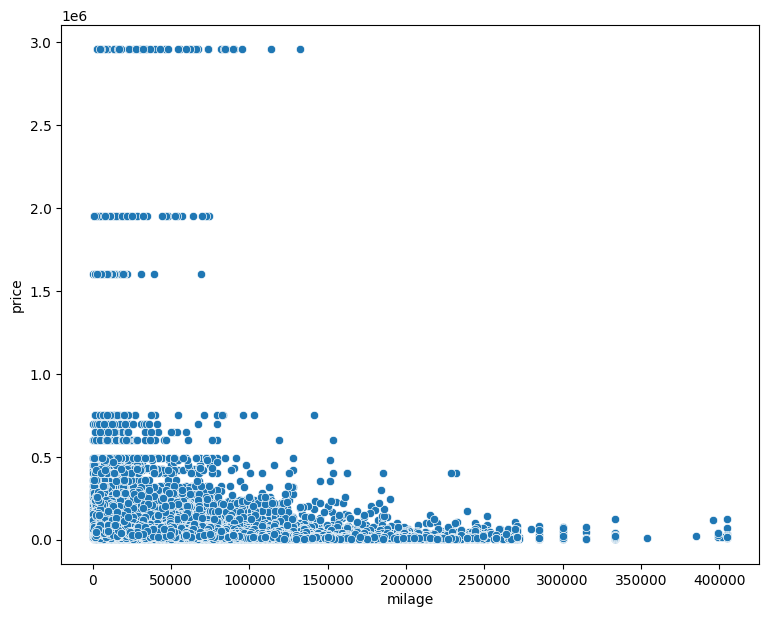

In [58]:
plt.figure(figsize=(9, 7))
sns.scatterplot(data=dataset, x='milage', y='price')

In [59]:
dataset = dataset[dataset['price'] <= 749950]

<Axes: xlabel='milage', ylabel='price'>

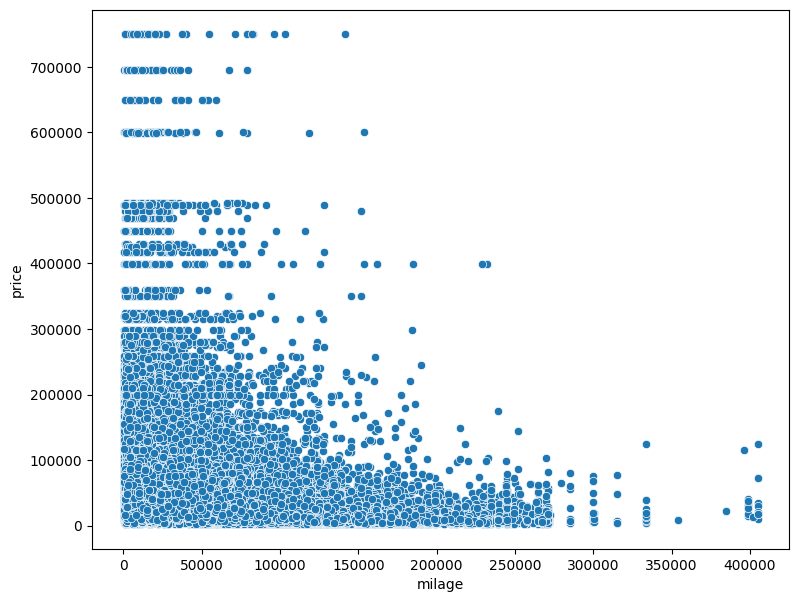

In [60]:
plt.figure(figsize=(9, 7))
sns.scatterplot(data=dataset, x='milage', y='price')

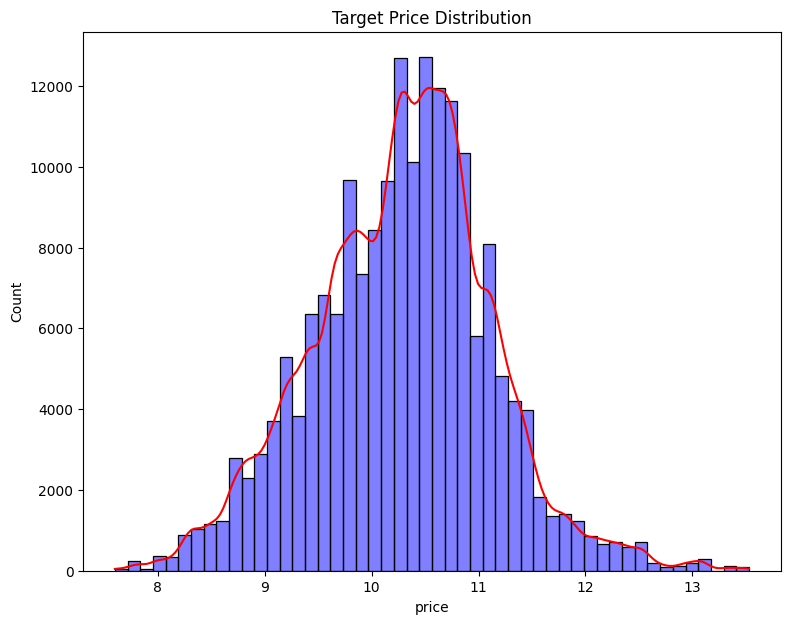

In [63]:
plt.figure(figsize=(9, 7))
sns.histplot(
    x = np.log(dataset['price']),
    stat='count',
    kde=True,
    bins=50,
    color='blue',
).lines[0].set_color('red')

plt.title('Target Price Distribution')
plt.show()

<Axes: xlabel='model_year', ylabel='price'>

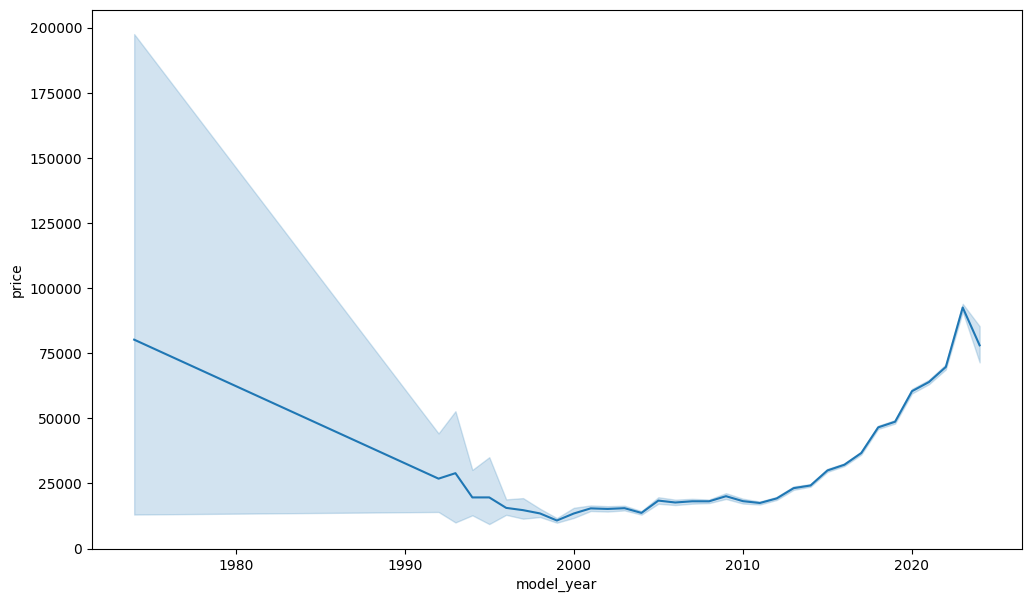

In [65]:
#  changes in price by model year
plt.figure(figsize=(12, 7))
sns.lineplot(data=dataset, x='model_year', y='price', markers=True)

Text(0.5, 1.0, 'Model Year Distribution (Count Plot)')

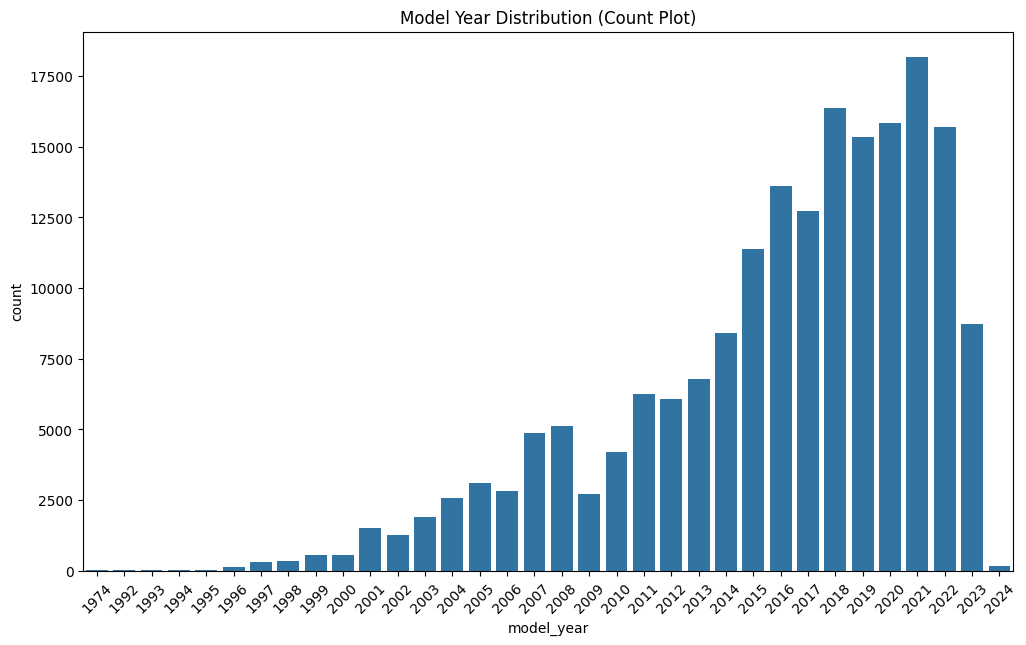

In [67]:
plt.figure(figsize=(12, 7))
a = sns.countplot(data=dataset, x='model_year', )
a.tick_params(axis='x', rotation=45)
plt.title('Model Year Distribution (Count Plot)')

In [68]:
current_year = datetime.now().year

dataset['car_age'] = current_year - dataset['model_year']

# function to categorize the cars based on age
def categorize_age(car_age):
    if car_age <= 5:
        return 'New'
    elif 6 <= car_age <= 20:
        return 'Middle-aged'
    else:
        return 'Old'
    

dataset['age_group'] = dataset['car_age'].apply(categorize_age)

In [69]:
dataset['age_group'].value_counts()

age_group
Middle-aged    106936
New             73989
Old              6666
Name: count, dtype: int64

C:\Users\tevyn\AppData\Local\Temp\ipykernel_19892\3522840263.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='age_group', ax=ax2, palette='Set2')


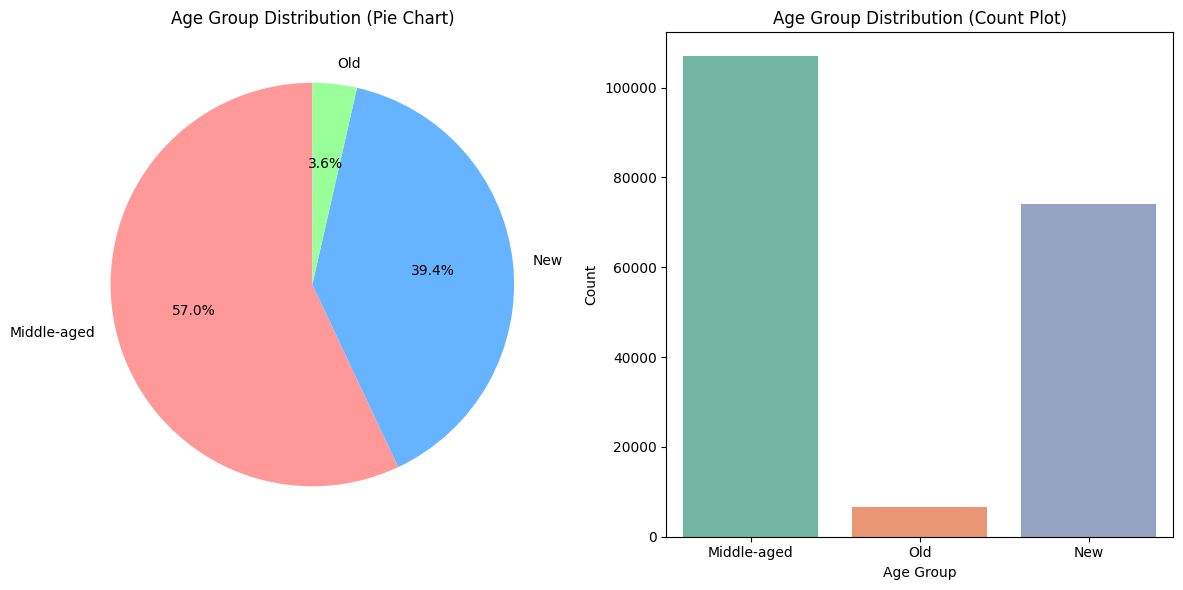

In [79]:
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 6))

age_group_counts = dataset['age_group'].value_counts()
ax1.pie(age_group_counts.values, labels=age_group_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax1.set_title('Age Group Distribution (Pie Chart)')

sns.countplot(data=dataset, x='age_group', ax=ax2, palette='Set2')
ax2.set_title('Age Group Distribution (Count Plot)')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [80]:
dataset.brand.nunique()

57

In [81]:
brand_groups = dataset.groupby('brand')['id'].count().sort_values(ascending=False).reset_index()
brand_groups.columns = ['Brand Name', 'Count']

brand_groups

,Brand Name,Count
0,Ford,22961
1,Mercedes-Benz,19141
2,BMW,17018
3,Chevrolet,16273
4,Audi,10882
5,Porsche,10536
6,Land,9510
7,Toyota,8789
8,Lexus,8634
9,Jeep,6454


In [82]:
top_brands = dataset['brand'].value_counts().head(10).index

df_top_brands = dataset[dataset['brand'].isin(top_brands)]

summary_stats = df_top_brands.groupby('brand')['price'].agg(['mean', 'median', 'min', 'max']).reset_index()
summary_stats.columns = ['Brand', 'Mean Price', 'Median Price', 'Min Price', 'Max Price']

summary_stats

,Brand,Mean Price,Median Price,Min Price,Max Price
0,Audi,40455.235251,29900.0,2000,749950
1,BMW,42957.631449,31000.0,2000,749950
2,Chevrolet,40461.407546,32000.0,2000,749950
3,Ford,38833.106616,32000.0,2000,749950
4,Jeep,34174.301673,29342.5,2000,749950
5,Land,50878.766246,38995.0,2000,749950
6,Lexus,33048.239518,25500.0,2000,649999
7,Mercedes-Benz,49558.957473,36570.0,2000,749950
8,Porsche,66437.755220,45858.0,2000,749950
9,Toyota,28485.399590,22000.0,2000,695000


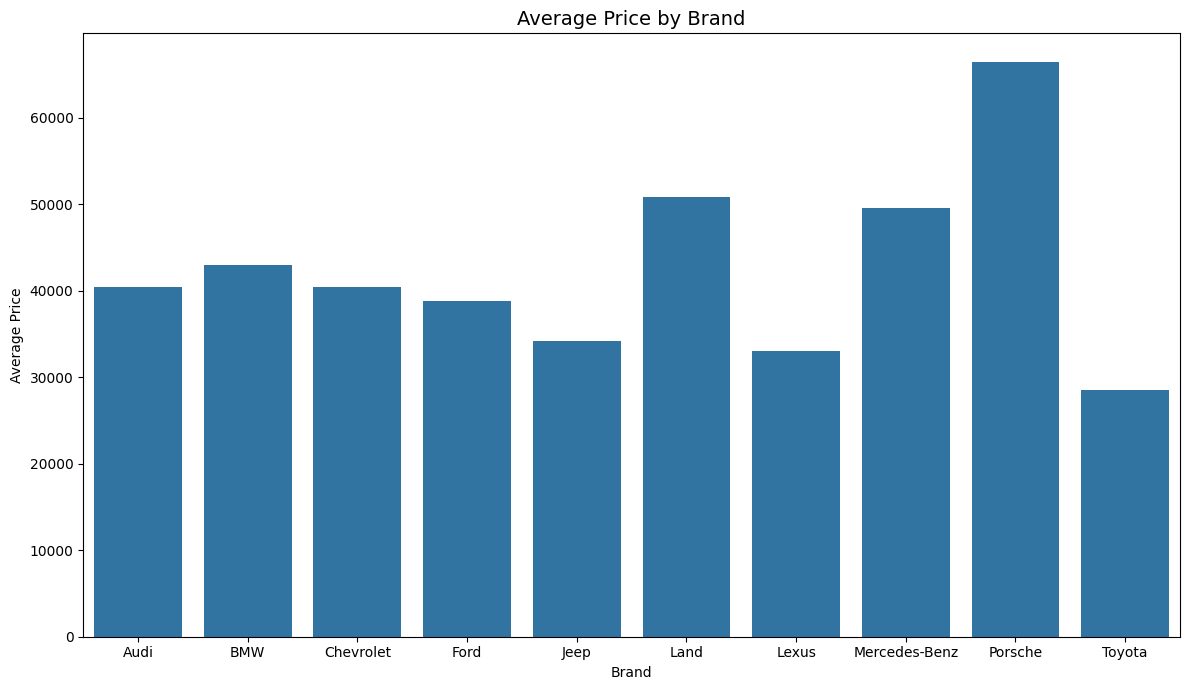

In [86]:
plt.figure(figsize=(12, 7))
sns.barplot(data=summary_stats, x='Brand', y='Mean Price', estimator='mean')

# plt.bar_label(B)
plt.title('Average Price by Brand', fontsize=14)
plt.xlabel('Brand')
plt.ylabel('Average Price')

plt.tight_layout()
plt.show()

In [87]:
luxurious_brands = [
    'Bentley', 'Porsche', 'Rolls-Royce', 'Jaguar', 'Ferrari', 'Lamborghini', 'Maserati', 'Bugatti', 'Aston', 'Maybach'
]

In [88]:
dataset['brand_type'] = dataset['brand'].apply(lambda x: 'luxurious' if x in luxurious_brands else 'normal')

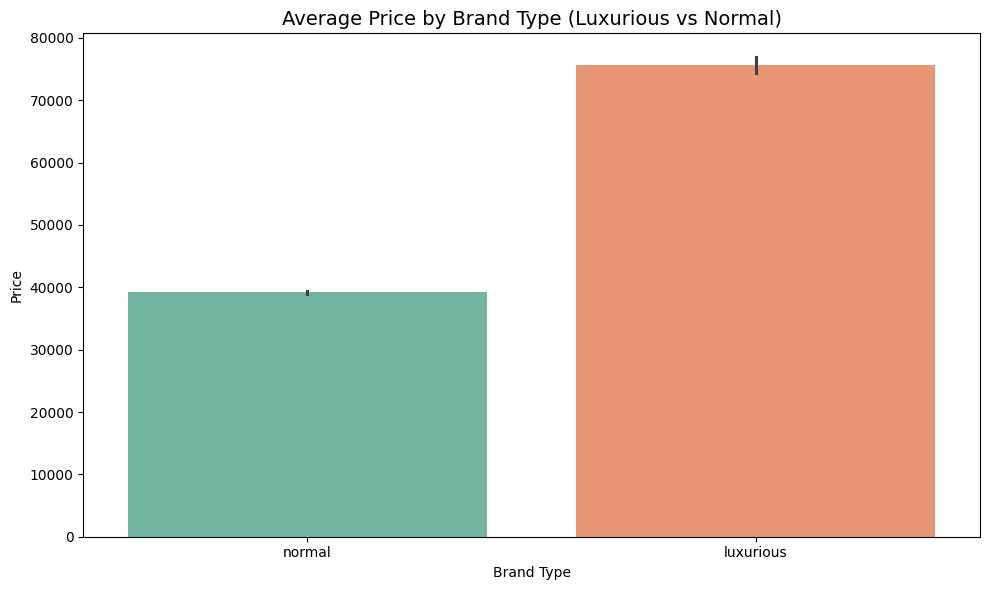

In [105]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=dataset, x='brand_type', y='price', hue='brand_type', estimator='mean', palette='Set2', legend='auto')

plt.title('Average Price by Brand Type (Luxurious vs Normal)', fontsize=14)
ax1.set_xlabel('Brand Type')
ax1.set_ylabel('Price')
# plt.legend()


plt.tight_layout()
plt.show()

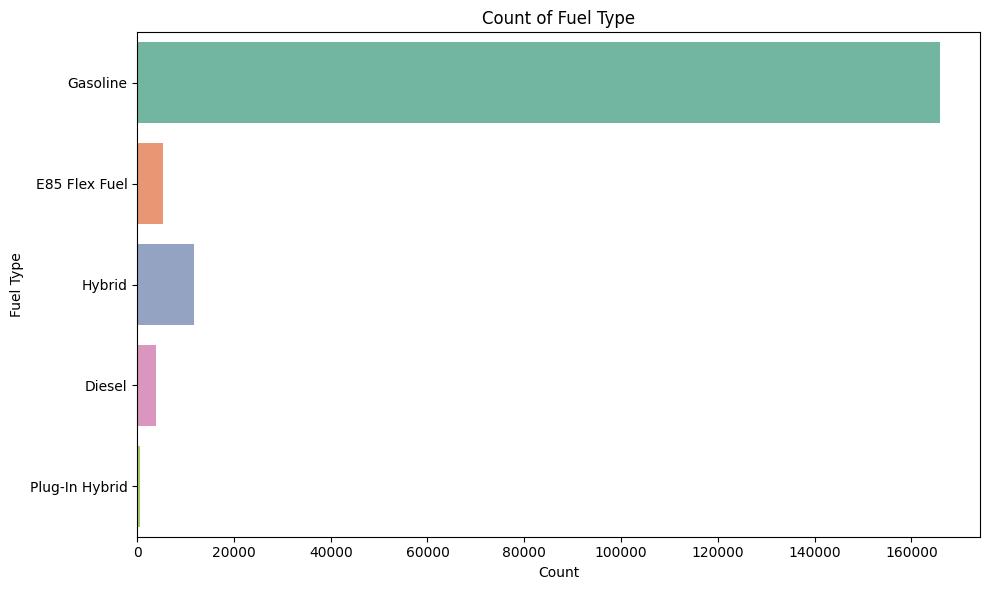

In [108]:
fig, ax1  = plt.subplots(figsize=(10, 6))

sns.countplot(data=dataset, y='fuel_type', hue='fuel_type', palette='Set2')

plt.title('Count of Fuel Type')
ax1.set_ylabel('Fuel Type')
ax1.set_xlabel('Count')

plt.tight_layout()
plt.show()

In [109]:
dataset['ext_col'].value_counts()

ext_col
Black                                 48513
White                                 43580
Gray                                  25162
Silver                                16907
Blue                                  14467
                                      ...  
GT SILVER                                 5
Granite Crystal Metallic Clearcoat        5
Blue Caelum                               4
BLUE                                      3
Mango Tango Pearlcoat                     2
Name: count, Length: 319, dtype: int64

In [110]:
top_10_colors = dataset['ext_col'].value_counts().head(10).index

df_colors = dataset[dataset['ext_col'].isin(top_10_colors)]

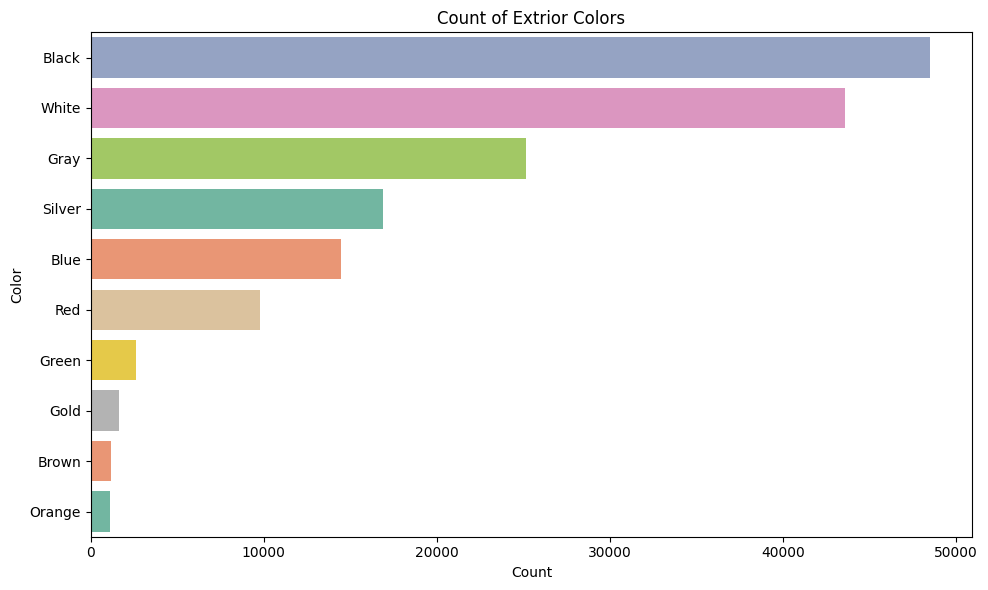

In [111]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.countplot(data=df_colors, y='ext_col', hue='ext_col', palette='Set2', order=df_colors['ext_col'].value_counts().index)

plt.title('Count of Extrior Colors')
ax.set_ylabel('Color')
ax.set_xlabel('Count')

plt.tight_layout()
plt.show()

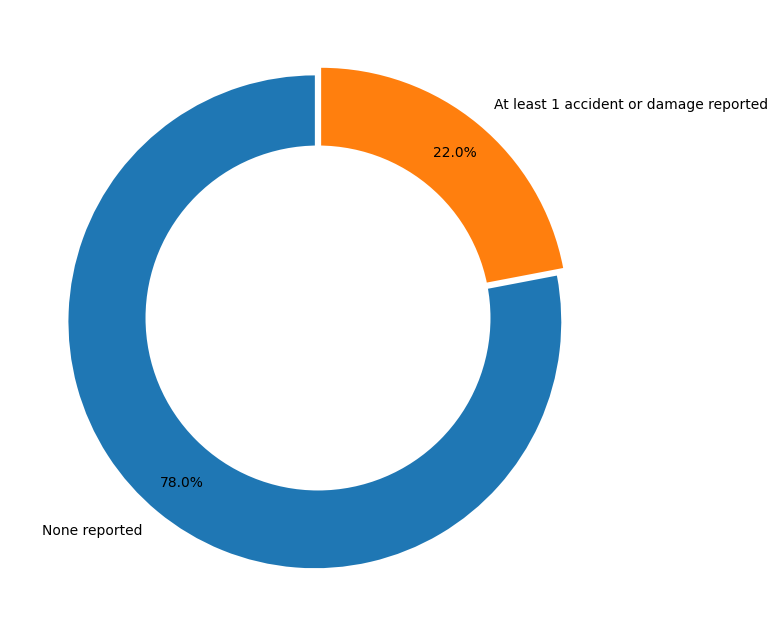

In [113]:
# Accident history
accident_history = dataset['accident'].value_counts()

accident_labels = accident_history.index
accident_value = accident_history.values

fig, ax = plt.subplots(figsize=(10, 8))

explode = np.full(len(accident_labels), 0.02)

ax.pie(accident_value, labels=accident_labels, autopct='%1.1f%%', startangle=90, explode=explode, pctdistance=0.85)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

In [114]:
# Transmission distribution
dataset['transmission'].value_counts()

transmission
A/T                                                   49496
8-Speed A/T                                           20610
Transmission w/Dual Shift Mode                        19198
6-Speed A/T                                           18019
6-Speed M/T                                           11881
7-Speed A/T                                           11110
Automatic                                             10682
8-Speed Automatic                                      8412
10-Speed A/T                                           8032
9-Speed A/T                                            3856
5-Speed A/T                                            3181
10-Speed Automatic                                     3156
6-Speed Automatic                                      2796
4-Speed A/T                                            2479
5-Speed M/T                                            2341
9-Speed Automatic                                      2321
CVT Transmission           

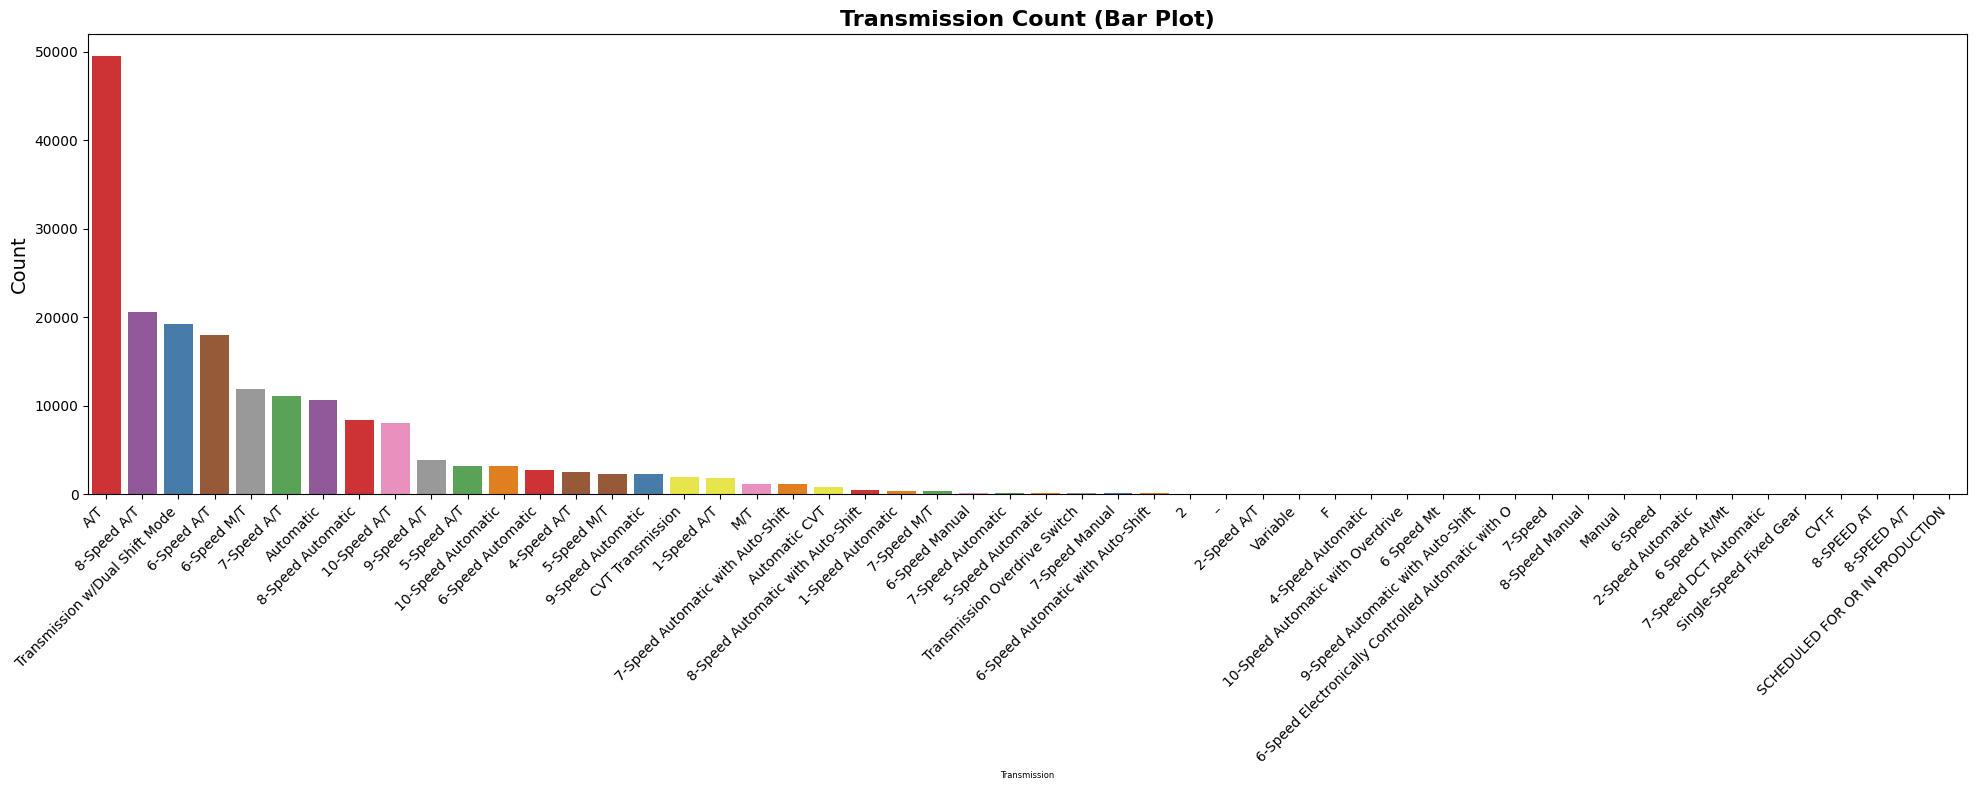

In [123]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.countplot(data=dataset, x='transmission', hue='transmission', order=dataset['transmission'].value_counts().index, palette='Set1')

plt.title('Transmission Count (Bar Plot)', fontsize=16, fontweight='bold')
# ax.set_xlabel('Transmission', fontsize=6)
# ax.set_ylabel('Count', fontsize=14)
# ax.tick_params(axis='x', rotation=45, ha='right')

plt.xlabel('Transmission', fontsize=6)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [124]:
dataset.transmission.unique()

array(['A/T', 'Transmission w/Dual Shift Mode', '7-Speed A/T',
       '8-Speed A/T', '10-Speed Automatic', '1-Speed A/T', '6-Speed A/T',
       '10-Speed A/T', '9-Speed A/T', '8-Speed Automatic',
       '9-Speed Automatic', '5-Speed A/T', 'Automatic',
       '7-Speed Automatic with Auto-Shift', 'CVT Transmission',
       '5-Speed M/T', 'M/T', '6-Speed M/T', '6-Speed Automatic',
       '4-Speed Automatic', '7-Speed M/T', '2-Speed A/T',
       '1-Speed Automatic', 'Automatic CVT', '4-Speed A/T',
       '6-Speed Manual', 'Transmission Overdrive Switch',
       '8-Speed Automatic with Auto-Shift', '7-Speed Manual',
       '7-Speed Automatic', '9-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift',
       '6-Speed Electronically Controlled Automatic with O', 'F', 'CVT-F',
       '8-Speed Manual', 'Manual', '–', '2', '6 Speed At/Mt',
       '5-Speed Automatic', '2-Speed Automatic', '8-SPEED A/T', '7-Speed',
       'Variable', 'Single-Speed Fixed Gear', '8-SPEED AT',


In [125]:
# simplify transmissions categorys

def categorize_transmission(trans_str):
    if pd.isna(trans_str):
        return 'Other'
    elif 'A/T' in trans_str or 'AT' in trans_str or 'Automatic' in trans_str or 'CVT' in trans_str:
        return 'Automatic'
    elif 'M/T' in trans_str or 'MT' in trans_str or 'Mt' in trans_str or 'Manual' in trans_str:
        return 'Manual'
    else:
        return 'Other'
    

dataset['transmission_type'] = dataset['transmission'].apply(categorize_transmission)
dataset['transmission_type'].value_counts()

transmission_type
Automatic    151643
Other         19730
Manual        16218
Name: count, dtype: int64

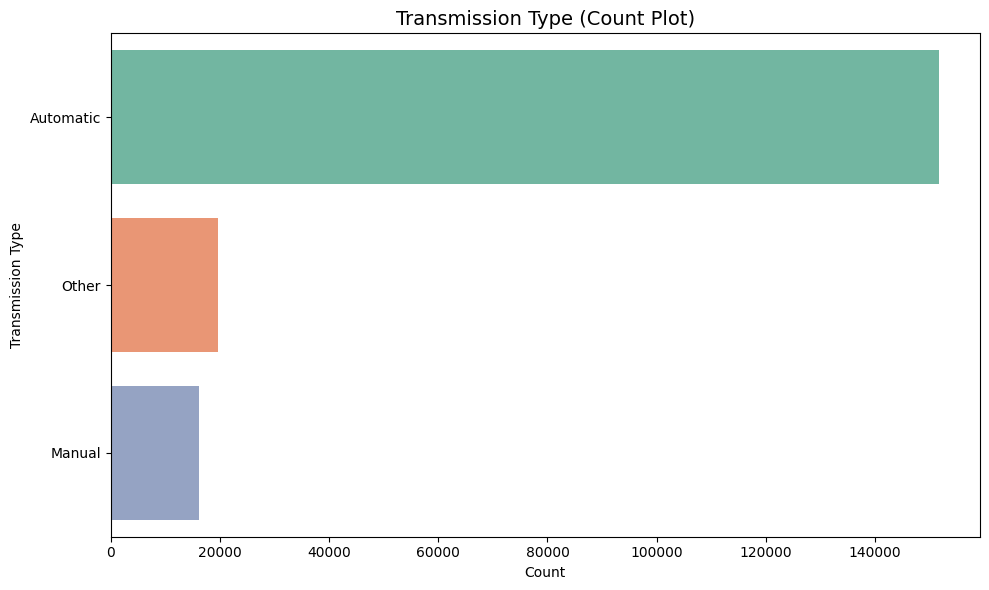

In [126]:
plt.figure(figsize=(10, 6))

sns.countplot(data=dataset, y='transmission_type', hue='transmission_type', palette='Set2')

plt.title('Transmission Type (Count Plot)', fontsize=14)
plt.ylabel('Transmission Type')
plt.xlabel('Count')

plt.tight_layout()
plt.show()


In [127]:
dataset['engine'].nunique()

1117

In [128]:
dataset['engine'][0]

'172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'

In [129]:
def extract_engine_size(engine_str):
    match = re.search(r'(\d+\.?\d*)\s*(L|Liter)', engine_str, re.IGNORECASE)
    if match:
        return float(match.group(1))
    return None

dataset['engine_size'] = dataset['engine'].apply(extract_engine_size)

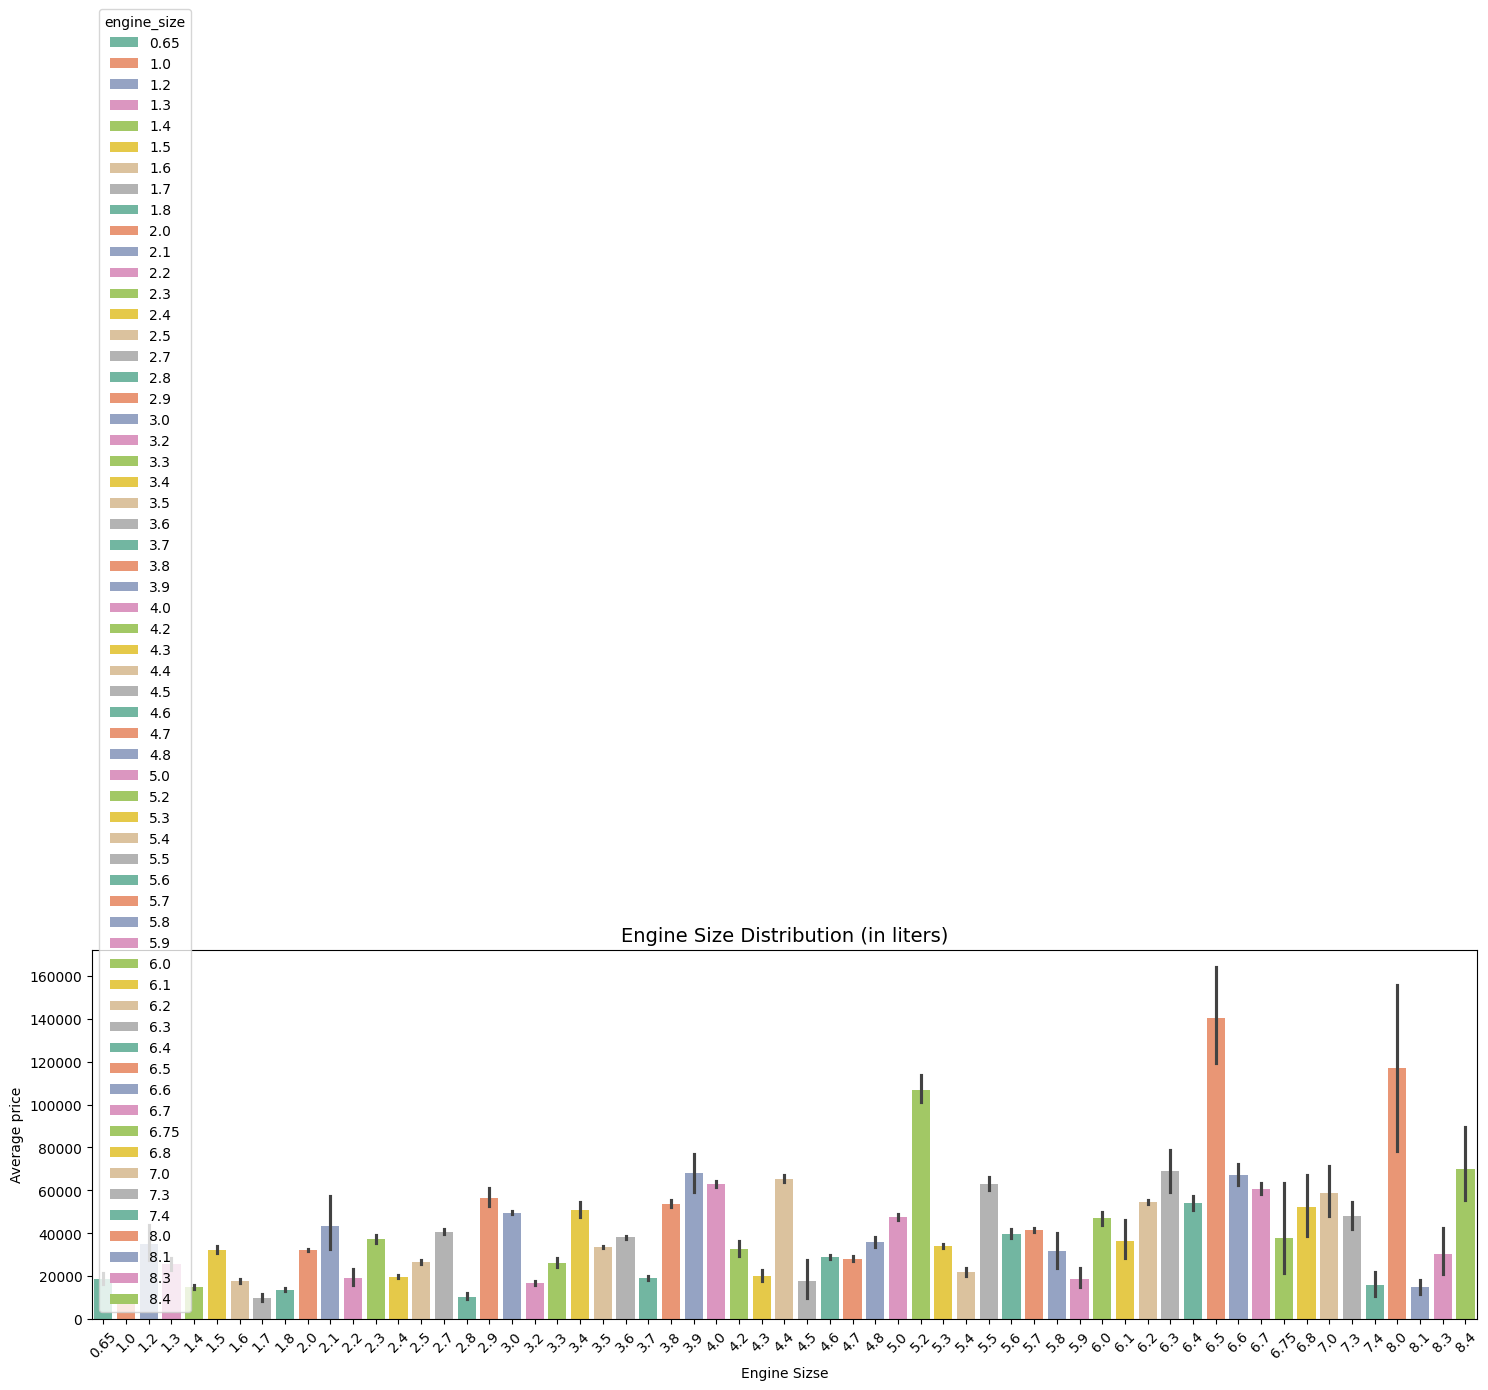

In [130]:
plt.figure(figsize= (15, 10))

sns.barplot(data=dataset, x='engine_size', y='price', hue='engine_size', estimator='mean', palette='Set2')

plt.title('Engine Size Distribution (in liters)', fontsize=14)
plt.xlabel('Engine Sizse')
plt.xticks(rotation=45)
plt.ylabel('Average price')

plt.tight_layout()
plt.show()

In [131]:
# Cylinder Cunt Distribution

def extract_cylinder_count(engine_str):
    match_explicit = re.search(r'(\d+)\s*Cylinder', engine_str)
    if match_explicit:
        return int(match_explicit.group(1))
    
    match_implicit = re.search(r'V(\d+)', engine_str)
    if match_implicit:
        return int(match_implicit.group(1))
    return None


dataset['cylinder_count'] = dataset['engine'].apply(extract_cylinder_count)

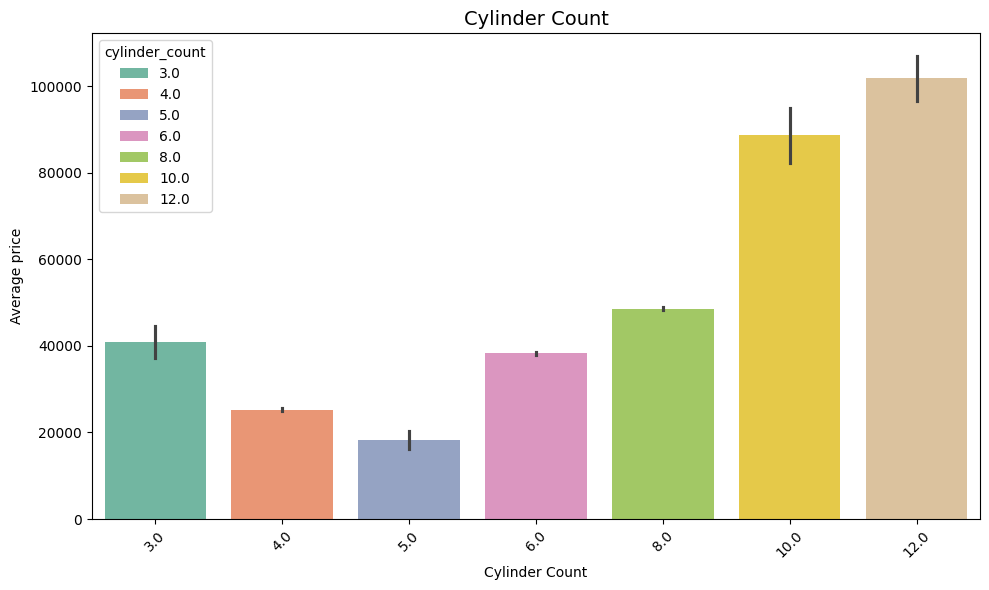

In [132]:
plt.figure(figsize=(10, 6))

sns.barplot(data=dataset, x='cylinder_count', y='price', hue='cylinder_count', estimator='mean', palette='Set2')

plt.title('Cylinder Count', fontsize=14)
plt.xlabel('Cylinder Count')
plt.xticks(rotation=45)
plt.ylabel('Average price')

plt.tight_layout()
plt.show()

In [133]:
# will create a new feature from milage column
#  to avoid inf values
dataset['car_age'] = dataset['car_age'].replace(0, 1)

dataset['milage_per_year'] = dataset['milage'] / dataset['car_age']

In [136]:
dataset['milage_per_year'].max()

235000.0

In [137]:
dataset.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'car_age', 'age_group', 'brand_type', 'transmission_type',
       'engine_size', 'cylinder_count', 'milage_per_year'],
      dtype='object')

In [138]:
train_data = dataset.copy()

In [139]:
# drop useless columns
train_data.drop(['id', 'brand', 'model', 'transmission', 'model_year', 'engine', 'clean_title', 'int_col', 'ext_col'], axis=1, inplace=True)

In [140]:
cat_mapper = [
    # Age group values order
    ['Old', 'Middle-aged', 'New'],
    # Brand type values order
    ['normal', 'luxurious']
]

In [141]:
train_data.columns

Index(['milage', 'fuel_type', 'accident', 'price', 'car_age', 'age_group',
       'brand_type', 'transmission_type', 'engine_size', 'cylinder_count',
       'milage_per_year'],
      dtype='object')

In [142]:
one_hot_encoder_features = ['fuel_type', 'transmission_type', 'accident']

ordinal_encoder_feature = ['age_group', 'brand_type']

standart_scalar_features = ['milage', 'car_age', 'milage_per_year']

all_features = one_hot_encoder_features + ordinal_encoder_feature + standart_scalar_features + ['cylinder_count', 'engine_size']

In [143]:
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_encoder_features),
        ('ordinal', OrdinalEncoder(categories=cat_mapper), ordinal_encoder_feature),
        ('num', StandardScaler(), standart_scalar_features)
    ],
)

In [145]:
X = train_data[all_features]
y = train_data['price']

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [147]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [148]:
print(X_train.shape)

(140693, 15)


In [149]:
# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [150]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

c:\Users\tevyn\.virtualenvs\cars-gjyHrDBP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [151]:
model.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [152]:
model.fit(X_train, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 2196227840.0000 - root_mean_squared_error: 46576.0547 - val_loss: 1564197504.0000 - val_root_mean_squared_error: 39549.9375
Epoch 2/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1691376256.0000 - root_mean_squared_error: 41102.5430 - val_loss: 1555316224.0000 - val_root_mean_squared_error: 39437.4961
Epoch 3/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1710206208.0000 - root_mean_squared_error: 41336.1016 - val_loss: 1561419776.0000 - val_root_mean_squared_error: 39514.8047
Epoch 4/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1709514880.0000 - root_mean_squared_error: 41330.1094 - val_loss: 1545966848.0000 - val_root_mean_squared_error: 39318.7852
Epoch 5/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 1746764288.0000 - root_mean_squared_error: 41774.0508 - val_loss: 1544118400.0000 - val_root_mean_squared_error: 39295.2734
Epoch 6/40
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 174589

In [153]:
model.evaluate(X_test, y_test)

1466/1466 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - loss: 1804604672.0000 - root_mean_squared_error: 42462.1680


[1790011392.0, 42308.52734375]

In [154]:
# submission
test_df = pd.read_csv('test.csv')

In [162]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 125690 non-null  int64  
 1   brand              125690 non-null  object 
 2   model              125690 non-null  object 
 3   model_year         125690 non-null  int64  
 4   milage             125690 non-null  int64  
 5   fuel_type          125690 non-null  object 
 6   engine             125690 non-null  object 
 7   transmission       125690 non-null  object 
 8   ext_col            125690 non-null  object 
 9   int_col            125690 non-null  object 
 10  accident           125690 non-null  object 
 11  clean_title        125690 non-null  object 
 12  car_age            125690 non-null  int64  
 13  age_group          125690 non-null  object 
 14  milage_per_year    125690 non-null  float64
 15  brand_type         125690 non-null  object 
 16  en

In [155]:
def process_df(df):

    # Flex
    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains('Flex', case=False, na=False)), 'fuel_type'] = 'E85 Flex Fuel'

    # Hybrid
    hybrid_conditions = [
        df['engine'].str.contains('Dual', case=False, na=False),
        df['engine'].str.contains('Electric', case=False, na=False),
        df['engine'].str.contains('Battery', case=False, na=False),
        df['engine'].str.contains('kW', case=False, na=False),
        df['engine'].str.contains('AH', case=False, na=False),
        df['brand'].str.contains('Tesla', case=False, na=False),
        df['model'].str.contains('Hybrid', case=False, na=False)
    ]
    df.loc[(df['fuel_type'].isna()) & (pd.concat(hybrid_conditions, axis=1).any(axis=1)), 'fuel_type'] = 'Hybrid'


    # Gasoline pattern
    gasoline_conditions = [
        df['engine'].str.contains('GDI', case=False, na=False),
        df['engine'].str.contains('PDI', case=False, na=False),
        df['engine'].str.contains('OHV', case=False, na=False),
        df['engine'].str.contains('MPFI', case=False, na=False),
        df['engine'].str.contains('TFSI', case=False, na=False),
        df['engine'].str.contains('DOHC', case=False, na=False),
        df['engine'].str.contains('Gasoline', case=False, na=False),
        df['model_year'] < 2020
    ]
    df.loc[(df['fuel_type'].isna()) & (pd.concat(gasoline_conditions, axis=1).any(axis=1)), 'fuel_type'] = 'Gasoline'

    # Diesel pattern
    df.loc[(df['fuel_type'].isna()) & (df['engine'].str.contains('Diesel', case=False, na=False)), 'fuel_type'] = 'Diesel'

    df['fuel_type'] = df['fuel_type'].fillna('Hybrid')

    df.loc[(df['accident'] == 'At least 1 accident or damage reported') & (df['clean_title'].isna()), 'clean_title'] = 'Yes'
    df['clean_title'] = df['clean_title'].fillna('No')
    df['accident'] = df['accident'].fillna('None reported')

    df['car_age'] = current_year - df['model_year']
    df['age_group'] = df['car_age'].apply(categorize_age)

    df['car_age'] = df['car_age'].replace(0, 1)
    df['milage_per_year'] = df['milage'] / df['car_age']

    df['brand_type'] = df['brand'].apply(lambda x: 'luxurious' if x in luxurious_brands else 'normal')

    df['engine_size'] = df['engine'].apply(extract_engine_size)
    df['cylinder_count'] = df['engine'].apply(extract_cylinder_count)
    most_frequent_engine_size = df['engine_size'].mode()[0]
    df['engine_size'] = df['engine_size'].fillna(most_frequent_engine_size)
    df['cylinder_count'] = df['cylinder_count'].fillna(0)

    df['transmission_type'] = df['transmission'].apply(categorize_transmission)

    return df

In [156]:
processed_test = process_df(test_df)

In [157]:
encoded_test = preprocessor.transform(processed_test[all_features])

In [158]:
y_pred = model.predict(encoded_test)

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 4s 901us/step


In [159]:
y_pred = y_pred.reshape(-1,)

In [160]:
output = pd.DataFrame({'id': test_df.id, 'price': y_pred})
output.to_csv('submission.csv', index=False)

In [161]:
output

,id,price
0,188533,21911.148438
1,188534,70722.664062
2,188535,59092.230469
3,188536,31281.308594
4,188537,36779.394531
...,...,...
125685,314218,21625.275391
125686,314219,52734.476562
125687,314220,20275.361328
125688,314221,14631.155273
